In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from load import read_csv

from pycox.evaluation import EvalSurv

from dataset import Dataset
from fedcox import Federation
from net import MLP 
from discretiser import Discretiser
from interpolate import surv_const_pdf, surv_const_pdf_df

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tabulate import tabulate

from torch.utils.data import DataLoader



In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
datapath = './Data/data.csv'
data = read_csv(datapath)
print(len(data))

40018


In [4]:
df_test = data.sample(frac=0.2)
df_train = data.drop(df_test.index)
df_val = df_train.sample(frac=0.1)
df_train = df_train.drop(df_val.index)

In [5]:
m_brain = df_test['SITE_C71'] == 1
m_other = (df_test['SITE_C70'] == 1) | (df_test['SITE_C72'] == 1)
benign = (df_test['SITE_D32'] == 1) | (df_test['SITE_D33'] == 1) | (df_test['SITE_D35'] == 1)

print('malignant brain: ',m_brain.sum())
print('malignant other: ',m_other.sum())
print('benign: ',benign.sum())

overlap = (m_brain & m_other & benign).sum()
print(overlap)


malignant brain:  3867
malignant other:  192
benign:  3951
0


In [6]:
# cols = list(df_train.columns.values)
# print(cols)
df_train = df_train[['GRADE', 'AGE', 'SEX', 'QUINTILE_2015', 'TUMOUR_COUNT', 'SACT', 'REGIMEN_COUNT', 'CLINICAL_TRIAL_INDICATOR', 'CHEMO_RADIATION_INDICATOR', 'NORMALISED_HEIGHT', 'NORMALISED_WEIGHT', 'BENIGN_BEHAVIOUR', 'SITE_C70', 'SITE_C71', 'SITE_C72', 'SITE_D32', 'SITE_D33', 'SITE_D35', 'CREG_L0201', 'CREG_L0301', 'CREG_L0401', 'CREG_L0801', 'CREG_L0901', 'CREG_L1001', 'CREG_L1201', 'CREG_L1701', 'LAT_9', 'LAT_B', 'LAT_L', 'LAT_M', 'LAT_R', 'ETH_A', 'ETH_B', 'ETH_C', 'ETH_M', 'ETH_O', 'ETH_U', 'ETH_W', 'DAYS_TO_FIRST_SURGERY','DAYS_SINCE_DIAGNOSIS','EVENT']]
df_train.head()

,GRADE,AGE,SEX,QUINTILE_2015,TUMOUR_COUNT,SACT,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,...,ETH_A,ETH_B,ETH_C,ETH_M,ETH_O,ETH_U,ETH_W,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS,EVENT
0,4,69.0,1,4.0,2,0,0.0,0,0,0.000,...,0,0,0,0,0,0,1,0,751,0
1,4,88.0,1,1.0,2,1,5.0,1,1,1.755,...,0,0,0,0,0,0,1,0,17,1
2,4,79.0,1,2.0,2,0,0.0,0,0,0.000,...,0,0,0,0,0,0,1,0,252,1
5,-1,28.0,1,1.0,2,0,0.0,0,0,0.000,...,0,0,0,0,0,1,0,0,839,0
7,-1,65.0,1,2.0,2,0,0.0,0,0,0.000,...,0,0,0,0,0,0,1,12,770,0


In [7]:
cols_standardise = ['GRADE', 'AGE', 'QUINTILE_2015', 'NORMALISED_HEIGHT', 'NORMALISED_WEIGHT']
cols_minmax = ['SEX', 'TUMOUR_COUNT', 'REGIMEN_COUNT']
cols_leave = ['SACT', 'CLINICAL_TRIAL_INDICATOR', 'CHEMO_RADIATION_INDICATOR','BENIGN_BEHAVIOUR','SITE_C70', 'SITE_C71', 'SITE_C72', 'SITE_D32','SITE_D33','SITE_D35','CREG_L0201','CREG_L0301','CREG_L0401','CREG_L0801','CREG_L0901','CREG_L1001','CREG_L1201','CREG_L1701','LAT_9','LAT_B','LAT_L','LAT_M','LAT_R','ETH_A','ETH_B','ETH_C','ETH_M','ETH_O','ETH_U','ETH_W','DAYS_TO_FIRST_SURGERY']

print(len(df_train.columns) == len(cols_standardise + cols_minmax + cols_leave))

standardise = [([col], StandardScaler()) for col in cols_standardise]
minmax = [([col], MinMaxScaler()) for col in cols_minmax]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardise + minmax + leave)

False


In [8]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [9]:
num_durations = 50

discretiser = Discretiser(num_durations, scheme='km')

y_train = (df_train.DAYS_SINCE_DIAGNOSIS.values, df_train.EVENT.values)
y_train = discretiser.fit_transform(*y_train)

y_val = (df_val.DAYS_SINCE_DIAGNOSIS.values, df_val.EVENT.values)
y_val = discretiser.transform(*y_val)
val_laoder = DataLoader(Dataset(x_val, y_val), batch_size=256, shuffle=False)

y_test = (df_test.DAYS_SINCE_DIAGNOSIS.values, df_test.EVENT.values)
test_loader = DataLoader(Dataset(x_test, y_test), batch_size=256, shuffle=False)

/Users/kaizhang/Work/PhD/FL-sim/flenv/lib/python3.8/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/Users/kaizhang/Work/PhD/FL-sim/flenv/lib/python3.8/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/Users/kaizhang/Work/PhD/FL-sim/flenv/lib/python3.8/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/Users/kaizhang/Work/PhD/FL-sim/flenv/lib/python3.8/site-packages/lifelines/fitters/__init__.py:2

In [10]:
dim_in = x_train.shape[1]
num_nodes = [32, 32]
dim_out = len(discretiser.cuts)
batch_norm = True
dropout = 0.1

net = MLP(dim_in=dim_in, num_nodes=num_nodes, dim_out=dim_out, batch_norm=batch_norm, dropout=dropout)

num_centers = 1
optimizer = 'adam'
lr = 0.001


32 50 True
<class 'int'> <class 'int'>


In [11]:
fed = Federation(features=x_train, labels=y_train, net=net, num_centers=num_centers, optimizer=optimizer, lr=lr, batch_size=256, local_epochs=5)
fed.fit(epochs=2)


 | Global Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 | [0/23050 (0%)]	Loss: 23.698534
| Global Round : 0 | Local Epoch : 0 | [2560/23050 (11%)]	Loss: 23.328930
| Global Round : 0 | Local Epoch : 0 | [5120/23050 (22%)]	Loss: 22.632278
| Global Round : 0 | Local Epoch : 0 | [7680/23050 (33%)]	Loss: 22.720388
| Global Round : 0 | Local Epoch : 0 | [10240/23050 (44%)]	Loss: 21.425486
| Global Round : 0 | Local Epoch : 0 | [12800/23050 (55%)]	Loss: 20.964520
| Global Round : 0 | Local Epoch : 0 | [15360/23050 (66%)]	Loss: 22.515278
| Global Round : 0 | Local Epoch : 0 | [17920/23050 (77%)]	Loss: 20.819328
| Global Round : 0 | Local Epoch : 0 | [20480/23050 (88%)]	Loss: 20.024544
| Global Round : 0 | Local Epoch : 0 | [900/23050 (99%)]	Loss: 22.043304
| Global Round : 0 | Local Epoch : 1 | [0/23050 (0%)]	Loss: 18.222576
| Global Round : 0 | Local Epoch : 1 | [2560/23050 (11%)]	Loss: 17.312586
| Global Round : 0 | Local Epoch : 1 | [5120/23050 (22%)]	Loss: 16.678732
| Global 

In [12]:
surv = fed.predict_surv(test_loader)[0]
surv = surv_const_pdf_df(surv, discretiser.cuts)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

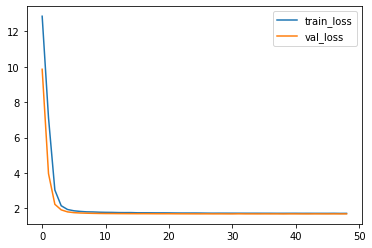

In [ ]:
ev = EvalSurv(surv, *y_test, censor_surv='km')
ev.concordance_td('antolini')